#  <span style="text-decoration:underline;">Assignment 2</span>: Clustering Yelp Data

## Introduction 

In this assignment, we will be working with the [Yelp data set](http://cs-people.bu.edu/bahargam/506/yelp_dataset_challenge_academic_dataset.tar). You can find information about the format of the data set [here](https://www.yelp.com/dataset_challenge).

## Submission 

Please use the following invitation link to create your assignment repository for this assignment: [https://classroom.github.com/a/nowbCi7s](https://classroom.github.com/a/nowbCi7s). Include your BU username within your submission by adding it here:

**<U81612345, xin he>;**.

Do not delete the output of your code cells. This assignment must be completed **individually** by each student.

## <span style="text-decoration:underline;">Problem 1</span>: Clustering, Scaling, and Visualizing

**<span style="text-decoration:underline;">Part A</span> (35 points):** From the Business Objects data set (`yelp_academic_dataset_business.json`), we want to find culinary districts in Las Vegas. These districts are characterized by the physical proximity and similarity of restaurants. We can use `longitude` and `latitude` to cluster for proximity, and `categories` to cluster for similarity. Only a subset (the top 15) of the most popular categories should be used.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using $k$-means++ (you are permitted to use the implementation available in scikit-learn). Explain your data representation and how you determined the number of clusters in $k$-means++.

**<span style="text-decoration:underline;">Part B</span> (15 points):** Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned.

Note that some categories are inherently more common (e.g., "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import pandas as pd
from collections import Counter
import numpy as np
from sklearn import preprocessing
import math
from sklearn.decomposition import TruncatedSVD

In [2]:
# filter city == Las Vegas and have Restaurant in catalog
# read json file and drop the non-needed column for clarity
df = pd.read_json('yelp_academic_dataset_business.json',lines=True)

# filt city == las vegas
df = df[df['city'] == 'Las Vegas']
# filt categories with restaurants
for index, row in df.iterrows():
    if "Restaurants" not in row['categories']:
        df = df.drop(index)
# for Problem2
df_bus = df.drop(['attributes','full_address','hours'
                                ,'name','neighborhoods','open','stars',
                                'review_count','state','type'],axis=1).copy()
# drop the unused attributes for clarity
df = df.drop(['attributes','full_address','hours'
                                ,'name','neighborhoods','open','stars',
                                'review_count','state','type'],axis=1)
# at this time we get all the restaurants in Las Vegas
df

,business_id,categories,city,latitude,longitude
7984,_SM8UKIwBNbmj1r629ipoQ,"[Wine Bars, Bars, Restaurants, Nightlife, Ital...",Las Vegas,36.193609,-115.304009
8226,l6QcUE8XXLrVH6Ydm4GSNw,"[Burgers, American (Traditional), Fast Food, R...",Las Vegas,36.197409,-115.191385
8290,AgtFQVxo-PGQVsOdY6Nvdg,"[Pizza, Restaurants]",Las Vegas,35.999205,-115.107474
8297,muqFM9Hoamh_fGL4MPeZqg,"[Pubs, Bars, Nightlife, Irish, Restaurants]",Las Vegas,36.017605,-115.117891
8488,AFDFOs2GaIyUArGyEUDQzQ,"[Chinese, Restaurants]",Las Vegas,36.125908,-115.197904
8489,FV16IeXJp2W6pnghTz2FAw,"[Vietnamese, Chinese, Restaurants]",Las Vegas,36.126177,-115.193971
8496,cvJDHk1ho0DxaF26etcr8Q,"[Latin American, Colombian, Restaurants]",Las Vegas,36.142935,-115.207747
8500,10UcN8MF1kQiyTJAfHKvfQ,"[Delis, Italian, Sandwiches, Restaurants]",Las Vegas,36.145596,-115.187588
8503,R5e2XWtpa_CA77MIXEyCTg,"[Fast Food, Sandwiches, Restaurants]",Las Vegas,36.130335,-115.206002
8507,CoJivG0wxNIBXyOF7MNqSQ,"[Vietnamese, Restaurants]",Las Vegas,36.125381,-115.195980


In [3]:
# find the top 15 catelogies and remove some bad catalog
li = []
# append all the categort in a list
for index, row in df.iterrows():
    for item in row['categories']:
        li.append(item)
# count the occurence of all the catelogies
d = Counter(li)
df_occur = pd.DataFrame.from_dict(d, orient='index')
df_occur.rename(columns={0:'times'}, inplace=True)
# find top 15 catelog, there I discard some useless data
df_occur = df_occur.sort_values('times',ascending = 0)
# drop some no-meaning data
df_occur = df_occur.drop(['Restaurants'],axis = 0)
df_occur = df_occur.drop(['Food'],axis = 0)
df_occur = df_occur.drop(['Fast Food'],axis = 0)
df_occur = df_occur.drop(['Bars'],axis = 0)
df_occur = df_occur.head(15)
res = df_occur.index.values
res = np.array(res).tolist()
# at this time we get top 15 catelogs
res
# this will be used later
top_catalog = res
top_catalog

['Mexican',
 'American (Traditional)',
 'Pizza',
 'Nightlife',
 'Sandwiches',
 'Burgers',
 'Chinese',
 'American (New)',
 'Italian',
 'Japanese',
 'Breakfast & Brunch',
 'Seafood',
 'Sushi Bars',
 'Steakhouses',
 'Barbeque']

In [4]:
# extract all the top 15 catalog as feature
cata_arr = []
location_arr = []
for index,data in df.iterrows():
    types = data["categories"]
    tmp = []
    has_top = 0
    for c in top_catalog:
        if c in types:
            has_top = 1
            tmp.append(1)
        else:
            tmp.append(0)  
    if has_top: 
        cata_arr.append(tmp)
        location = df[df.index == index][["longitude","latitude"]].values.tolist()
        location_arr += location
# make all the catalog feature / 15, because i will make longtitude and latitude to 0 to 1
for i in range(len(cata_arr)):
    for j in range(len(cata_arr[i])):
        cata_arr[i][j] /= 15

In [5]:
# scale all the location information to 0 to 1
min_max_scaler = preprocessing.MinMaxScaler()
scale_location = min_max_scaler.fit_transform(np.array(location_arr))
for i in range(len(cata_arr)):
    for j in range(len(scale_location[i])):
        cata_arr[i].append(scale_location[i][j])
top_catalog.append('longitude')
top_catalog.append('latitude')
top_catalog

['Mexican',
 'American (Traditional)',
 'Pizza',
 'Nightlife',
 'Sandwiches',
 'Burgers',
 'Chinese',
 'American (New)',
 'Italian',
 'Japanese',
 'Breakfast & Brunch',
 'Seafood',
 'Sushi Bars',
 'Steakhouses',
 'Barbeque',
 'longitude',
 'latitude']

In [6]:
# make the result to dataframe
cata_arr = np.asarray(cata_arr)
df = pd.DataFrame(data = cata_arr[0:,0:],columns=top_catalog)
df

,Mexican,American (Traditional),Pizza,Nightlife,Sandwiches,Burgers,Chinese,American (New),Italian,Japanese,Breakfast & Brunch,Seafood,Sushi Bars,Steakhouses,Barbeque,longitude,latitude
0,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.132460,0.625204
1,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.443965,0.635982
2,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.676051,0.073836
3,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.647238,0.126023
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.425934,0.433191
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.436812,0.433954
6,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.454467,0.489030
7,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.403536,0.445747
8,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.402667,0.482591
9,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428529,0.431839


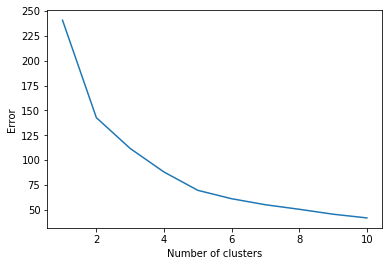

In [7]:
from sklearn.cluster import KMeans
feature_arr = np.array(df)
# find the K value
def evaluate_clusters(X, max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
evaluate_clusters(feature_arr,10)
# I think 8 is enought because is low enough

In [8]:
# using K means to cluster
k_cluster = 8
kmeans = KMeans(n_clusters = k_cluster, random_state=0).fit(feature_arr)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
df['clusters'] = labels
top_catalog.extend(['clusters'])
print(df[top_catalog].groupby(['clusters']).mean())
# print the mean of each cluster to see if the result is reasonalble

           Mexican  American (Traditional)     Pizza  Nightlife  Sandwiches  \
clusters                                                                      
0         0.014933                0.009067  0.006400   0.006044    0.008000   
1         0.009336                0.007732  0.010357   0.008315    0.007440   
2         0.007007                0.010680  0.006599   0.010612    0.007415   
3         0.011794                0.008026  0.012613   0.007371    0.009337   
4         0.010651                0.010651  0.011243   0.007101    0.010059   
5         0.009994                0.006702  0.006349   0.007407    0.006820   
6         0.009563                0.008197  0.009290   0.007104    0.010656   
7         0.019085                0.007320  0.010980   0.004967    0.006536   

           Burgers   Chinese  American (New)   Italian  Japanese  \
clusters                                                           
0         0.006400  0.004800        0.006400  0.003556  0.002489   
1    

In [9]:
# find top 10 clusters
top_clusters = df.groupby('clusters').sum()
top_clusters = top_clusters.drop(['longitude','latitude'],axis=1)
top_clusters.idxmax(axis=1)

clusters
0                   Mexican
1                     Pizza
2    American (Traditional)
3                     Pizza
4                     Pizza
5                   Chinese
6                Sandwiches
7                   Mexican
dtype: object

In [10]:
# give labels to cluster, which is most common catalog in this cluster
label = top_clusters.idxmax(axis=1).values
# for picture
df_pic = df.copy()
for i in range(len(label)):
    df_pic.loc[df_pic['clusters'] == i, 'clusters'] = label[i]

Text(40.414206814236124, 0.5, 'longitude')

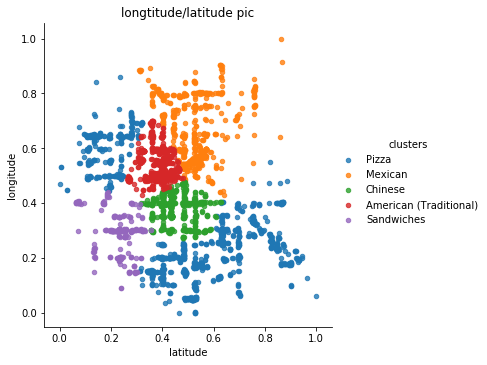

In [11]:
#Scatter plot of Wattage and Duration
sns.lmplot('latitude', 'longitude', data=df_pic, fit_reg=False, hue="clusters",  
           scatter_kws={"marker": "D", "s": 20})
plt.title('longtitude/latitude pic')
plt.xlabel('latitude')
plt.ylabel('longitude')
# 1.I use the function from our lecture to draw an error map. And we can see it from
# the map that 8 is not so many error and fast. 
# 2.and the clusters and really be found, they distributed away,some clusters has the same
# dominate catalog, so they have same color
# 3.I use catagory which appear most as label

## <span style="text-decoration:underline;">Problem 2</span>: Outliers and Unsupervised Clustering

**<span style="text-decoration:underline;">Part A</span> (15 points):** Detect the top five outliers for each cluster that you generated in Problem 1. These are the restaurants that are the farthest from the centroids of their clusters.

In [12]:
# centers for different clusters
centroids

array([[0.01493333, 0.00906667, 0.0064    , 0.00604444, 0.008     ,
        0.0064    , 0.0048    , 0.0064    , 0.00355556, 0.00248889,
        0.00373333, 0.00231111, 0.0016    , 0.00462222, 0.00373333,
        0.57624845, 0.53278308],
       [0.00933625, 0.00773158, 0.0103574 , 0.0083151 , 0.00743982,
        0.00671043, 0.004814  , 0.0075857 , 0.00773158, 0.00525164,
        0.00466813, 0.0027717 , 0.004814  , 0.00247994, 0.00189643,
        0.14996303, 0.46621579],
       [0.0070068 , 0.01068027, 0.00659864, 0.01061224, 0.00741497,
        0.00666667, 0.00462585, 0.00891156, 0.00653061, 0.0044898 ,
        0.00367347, 0.0047619 , 0.00265306, 0.00544218, 0.00142857,
        0.52927223, 0.38742037],
       [0.01179361, 0.00802621, 0.01261261, 0.00737101, 0.00933661,
        0.00638821, 0.00524161, 0.003276  , 0.00507781, 0.0029484 ,
        0.004095  , 0.0018018 , 0.0027846 , 0.001638  , 0.0031122 ,
        0.27206673, 0.74770775],
       [0.01065089, 0.01065089, 0.0112426 , 0.007100

In [13]:
# define eluclidean distance function
def eluclidean(arr1, arr2):
    count = 0
    for i in range(len(arr1)):
        count = count + (arr1[i] - arr2[i])**2
    return math.sqrt(count)

In [14]:
# get all the eluclidean distance
li = []
for index, row in df.iterrows():
    arr_el = row[:-1].values
    li.append(eluclidean(centroids[row['clusters'].astype(int)],arr_el))
df['eluclidean'] = li
df

,Mexican,American (Traditional),Pizza,Nightlife,Sandwiches,Burgers,Chinese,American (New),Italian,Japanese,Breakfast & Brunch,Seafood,Sushi Bars,Steakhouses,Barbeque,longitude,latitude,clusters,eluclidean
0,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.132460,0.625204,1,0.181624
1,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.443965,0.635982,0,0.188688
2,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.676051,0.073836,4,0.146611
3,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.647238,0.126023,4,0.098857
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.425934,0.433191,5,0.075623
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.436812,0.433954,5,0.082336
6,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.454467,0.489030,5,0.121374
7,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.403536,0.445747,5,0.068827
8,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.402667,0.482591,5,0.073667
9,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428529,0.431839,5,0.097734


In [15]:
# group them together and find the 5 Fatherst eluclidean distance
for i in range(k_cluster):
    top5 = df.loc[df['clusters'] == i].sort_values(by='eluclidean',
                                                         ascending=False).head(5)
    print(top_catalog[i] + " : ")
    print(top5)
    print("--------------------------------------------------------------------------------")

Mexican : 
       Mexican  American (Traditional)  Pizza  Nightlife  Sandwiches  \
1875  0.000000                0.000000    0.0   0.066667         0.0   
3550  0.066667                0.000000    0.0   0.066667         0.0   
1678  0.000000                0.066667    0.0   0.000000         0.0   
1406  0.000000                0.066667    0.0   0.000000         0.0   
2568  0.000000                0.000000    0.0   0.000000         0.0   

       Burgers  Chinese  American (New)  Italian  Japanese  \
1875  0.000000      0.0        0.066667      0.0       0.0   
3550  0.000000      0.0        0.066667      0.0       0.0   
1678  0.066667      0.0        0.000000      0.0       0.0   
1406  0.000000      0.0        0.000000      0.0       0.0   
2568  0.066667      0.0        0.000000      0.0       0.0   

      Breakfast & Brunch  Seafood  Sushi Bars  Steakhouses  Barbeque  \
1875                 0.0      0.0         0.0          0.0       0.0   
3550                 0.0      0.0      

**<span style="text-decoration:underline;">Part B</span> (35 points):** Cluster the restaurants using the text of the restaurant reviews (rather than the categories) in an unsupervised fashion. Use the document-term matrix approach and tf-idf. Finally, use one cluster comparison metric to compare your results from Problem 1 to your unsupervised clustering results from Problem 2.

In [16]:
# get the review data and drop all the noisy column
df_review = pd.read_json('yelp_academic_dataset_review.json',lines=True)
df_review = df_review.drop(['date','review_id','type','user_id','votes','stars'],axis=1)

In [17]:
# copy is for quick test
df_review_t = df_review.copy()
df_review_t = df_review_t.groupby('business_id').agg(lambda x : ' '.join(x)).reset_index()
df_review_t

,business_id,text
0,--1emggGHgoG6ipd_RMb-g,This gas station is exacty as I expected. It ...
1,--4Pe8BZ6gj57VFL5mUE8g,I am truly disappointed with Office Max. About...
2,--5jkZ3-nUPZxUvtcbr8Uw,"Great guys, great food. Plus right next to one..."
3,--BlvDO_RG2yElKu9XA1_g,Fast! Fresh!! Perfect! And that was just the f...
4,--Dl2rW_xO8GuYBomlg9zw,As a UNLV student I am luckily entitled to dis...
5,--Ol5mVSMaW8ExtmWRUmKA,"This is a great barber.\n\nFirst off, you won'..."
6,--UE_y6auTgq3FXlvUMkbw,Come for the drama between the waitresses in n...
7,--WLj8iK9DUKxkPnMHAoeA,"Had a nice stay. Although it's ""airport"" area ..."
8,--XBxRlD92RaV6TyUnP8Ow,"Yo, their store is awesome! That dude, Richar..."
9,--Y_2lDOtVDioX5bwF6GIw,"Went for lunch today (12/6/12), and thoroughly..."


In [18]:
# merge review longtitude, lengtitude and review together
# delete all the non-top 15 catalog data
for index,row in df_bus.iterrows():
    top = 0
    for i in row['categories']:
        if i in top_catalog:
            top = 1
    if top == 0:
        df_bus.drop(index, inplace=True)
df_review_t = df_bus.merge(df_review_t, left_on='business_id', right_on='business_id')
df_review_t

,business_id,categories,city,latitude,longitude,text
0,_SM8UKIwBNbmj1r629ipoQ,"[Wine Bars, Bars, Restaurants, Nightlife, Ital...",Las Vegas,36.193609,-115.304009,"I like Chianti, the outdoor seating area is ni..."
1,l6QcUE8XXLrVH6Ydm4GSNw,"[Burgers, American (Traditional), Fast Food, R...",Las Vegas,36.197409,-115.191385,I stopped eating red meat for a while. Decide...
2,AgtFQVxo-PGQVsOdY6Nvdg,"[Pizza, Restaurants]",Las Vegas,35.999205,-115.107474,I hadn't had Pizza Hut in years! My dad just ...
3,muqFM9Hoamh_fGL4MPeZqg,"[Pubs, Bars, Nightlife, Irish, Restaurants]",Las Vegas,36.017605,-115.117891,A great local hangout.. Not real keen on the f...
4,AFDFOs2GaIyUArGyEUDQzQ,"[Chinese, Restaurants]",Las Vegas,36.125908,-115.197904,This place has excellent pan fried Sea Bass. ...
5,FV16IeXJp2W6pnghTz2FAw,"[Vietnamese, Chinese, Restaurants]",Las Vegas,36.126177,-115.193971,Me and la familia ate here 3 times over my 3 n...
6,10UcN8MF1kQiyTJAfHKvfQ,"[Delis, Italian, Sandwiches, Restaurants]",Las Vegas,36.145596,-115.187588,Homestyle Cooking for CHEAP!! $4.95 Breakfast ...
7,R5e2XWtpa_CA77MIXEyCTg,"[Fast Food, Sandwiches, Restaurants]",Las Vegas,36.130335,-115.206002,This Subway and the company really suck. Don'...
8,pCobXgTy6DIfBaT4pjlq0w,"[Sandwiches, Restaurants]",Las Vegas,36.143326,-115.206316,love the schmears. love the new breakfast bage...
9,qbXEkNp310Mc0CIs0YJdSg,"[Chinese, Food, Specialty Food, Juice Bars & S...",Las Vegas,36.125431,-115.196966,This place is seriously the best place to go f...


In [19]:
# find text_array as input of tfidf  
text_arr = np.asarray(df_review_t['text'])
text_arr

array(['I like Chianti, the outdoor seating area is nice during the spring and fall, while the inside typifies an average Las Vegas dinner spot. The staff is attentive. Entrees are tasty, I liked the beef carpaccio appetizer, as well as the nice, simple pasta dishes and pizzas, and the cioppino is (surprisingly) pretty good too (although the tomato broth is a little overwhelming and the seafood is obviously not coastal fresh). The bread/crostini is horrible (ala white Wonder Bread). Decent wine list, but less than helpful staff in that regard. Overall, I would recommend this spot to anyone stranded in Vegas and craving a bowl of cioppino (p.s., if you know of a better spot for cioppino in Vegas please let me know). My wife and I went to Chianti for our anniversary.  And, we had a 20% off coupon.  We started with the garlic bread and as an appy ordered the cheesy artichoke dip (Carciofi Gratinati).  Both were wonderful, as were the drinks on the specials menu.  For our entrees, we order

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=4, max_df=0.8)
data = vectorizer.fit_transform(text_arr)
data

<3623x40810 sparse matrix of type '<class 'numpy.float64'>'
	with 4350518 stored elements in Compressed Sparse Row format>

In [21]:
# put all the text feature in to SVD to create a one dimensional feature to dataframe
svd = TruncatedSVD(n_components= 1, random_state=42)
text_feature = svd.fit_transform(data) 
df_review_t['text_weight'] = text_feature
df_review_t = df_review_t.drop(['text','business_id','city','categories'],axis=1)
df_review_t

,latitude,longitude,text_weight
0,36.193609,-115.304009,0.338569
1,36.197409,-115.191385,0.268504
2,35.999205,-115.107474,0.330049
3,36.017605,-115.117891,0.264254
4,36.125908,-115.197904,0.485054
5,36.126177,-115.193971,0.209156
6,36.145596,-115.187588,0.150350
7,36.130335,-115.206002,0.209233
8,36.143326,-115.206316,0.181141
9,36.125431,-115.196966,0.093403


In [22]:
# rescale the 3 dimentions
min_max_scaler = preprocessing.MinMaxScaler()
df_scale = min_max_scaler.fit_transform(np.array(df_review_t))
df_scale

array([[0.62520442, 0.13246026, 0.43386456],
       [0.63598194, 0.44396475, 0.3257098 ],
       [0.0738365 , 0.676051  , 0.42071249],
       ...,
       [0.55571728, 0.58591622, 0.2398082 ],
       [0.25461903, 0.29257433, 0.34996639],
       [0.44123639, 0.51903994, 0.27712138]])

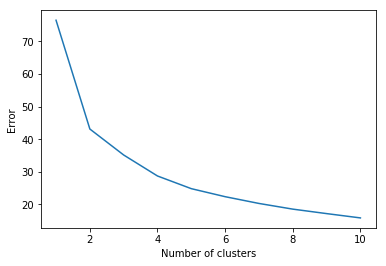

In [23]:
# find the clusters map
clmns = ['latitude','longitude','text_weight']
feature_arr = df_review_t.values
evaluate_clusters(feature_arr,10)

In [24]:
# using K means to cluster, we also use 8 clusters
kmeans = KMeans(n_clusters = k_cluster, random_state=45).fit(feature_arr)
labels_prob2 = kmeans.labels_
df_review_t['clusters'] = labels_prob2
clmns.extend(['clusters'])

In [25]:
# compare two labels
import sklearn.metrics as metrics
metrics.adjusted_rand_score(labels,labels_prob2)

0.1682341956899856